In [1]:
# !pip install nltk
# !pip install nltk==3.8.1
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
import pandas as pd
# trainData = pd.read_parquet('/content/sample_data/MovieGenreTraindata.parquet')
trainData = pd.read_parquet('/content/sample_data/TrainData.parquet')
print(trainData.shape)
# print(trainData.head())
import numpy as np
# Dropping unnecessary columns, keeping movie name, plot, genre
trainData = trainData.iloc[:, 2:4].to_numpy()
print(trainData[0])
print(trainData.shape)

(54000, 4)
['A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.'
 'fantasy']
(54000, 2)


In [4]:
# getting all class labels
genre = []

for row in trainData:
  if row[1] not in genre:
    genre.append(row[1])

print(genre)

['fantasy', 'horror', 'family', 'scifi', 'action', 'crime', 'adventure', 'mystery', 'romance', 'thriller']


**Exploratory data analysis (EDA)**

In [5]:
# let us check if any rows are missing label:
not_labelled = 0
for row in trainData:
  if row[1] == '':
    not_labelled += 1

print(not_labelled)

# number of times each label appears in training data:
label = {}

for row in trainData:
  if row[1] not in label:
    label[row[1]] = 0
  label[row[1]] += 1

print(label)

0
{'fantasy': 5400, 'horror': 5400, 'family': 5400, 'scifi': 5400, 'action': 5400, 'crime': 5400, 'adventure': 5400, 'mystery': 5400, 'romance': 5400, 'thriller': 5400}


###**Text pre-processing steps:**



Removing stopwords, special charactes and numbers to focus on words that matter

In [6]:
# remove special char and numbers from our plot
import re
import nltk
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
for idx in range(len(trainData)):
  # remove special char from our plot
  spl_char_removed = re.sub('\W+',' ', trainData[idx][0])
  # remove numbers from our plot
  num_removed = re.sub(r'\d+', ' ', spl_char_removed)
  # remove stop words from out plot
  stop_words = set(stopwords.words('english'))
  word_tokens = num_removed.split()
  stopword_removed = " ".join([w for w in word_tokens if not w.lower() in stop_words])
  trainData[idx][0] = stopword_removed
print(trainData[1])

['director friends renting haunted house capture paranormal events order prove become popular'
 'horror']


Lemmatization

In [7]:
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
for idx in range(len(trainData)):
  word_tokens = trainData[idx][0].split()
  lemma = " ".join(lemmatizer.lemmatize(w, pos='v') for w in word_tokens)
  trainData[idx][0] = lemma

print(trainData[1])

['director friends rent haunt house capture paranormal events order prove become popular'
 'horror']


###Splitting training and testing data

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
X = np.array([row[0] for row in trainData])
y = np.array([row[1] for row in trainData])
# shuffle is used to shuffle data and split between train and test.
# random state is used to capture the particular shuffle state so same state of shuffle can be used across models to compare
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=42, test_size=0.25, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40500,) (13500,) (40500,) (13500,)


###**Vectorizing input**

Bag Of Words Vectorization

In [10]:
import warnings
from sklearn.feature_extraction.text import CountVectorizer
# considering 1-gram, 2-gram and 3-gram words.
# max_features is used to consider that many most frequest terms while predicting label
count_vector = CountVectorizer(ngram_range = (1,3), max_features = 25000)
X_Train_BOW = count_vector.fit_transform(X_train)
BOW_Result = {}

TF-IDF Vectorization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
# if word freq is below min_df or above max_df ignore
tfidf_vector = TfidfVectorizer(ngram_range = (1,1), max_df=.80, min_df=25, lowercase=False)
X_Train_TF_IDF = tfidf_vector.fit_transform(X_train)
TFIDF_Result = {}

###**Model training and prediction**

**Logistic Regression**

In [12]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

grid_LogReg = {
    'estimator__C' : [0.01, 0.1, 1.0, 5],
    'estimator__penalty' : ['l2', 'l1'],
    'estimator__class_weight' : ['balanced', None],
    'estimator__solver' : ['lbfgs', 'liblinear']
}
log_reg = OneVsRestClassifier(LogisticRegression(random_state = 42))
# cv = cross validation in next cell

In [13]:
# BOW or count vector
log_reg_grid_search_BOW = GridSearchCV(log_reg, param_grid = grid_LogReg, cv = 5)# , error_score='raise')
# Supressing warning
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("ignore")
    log_reg_grid_search_BOW.fit(X_Train_BOW, y_train)

BOW_Result['LogisticRegression'] = log_reg_grid_search_BOW.best_score_

print("BOW Logistic Regression best score: ", log_reg_grid_search_BOW.best_score_)
print("BOW Logistic Regression cross validation result: ", log_reg_grid_search_BOW.cv_results_)
print("BOW Logistic Regression best parameters: ", log_reg_grid_search_BOW.best_params_)

BOW Logistic Regression best score:  0.3479259259259259
BOW Logistic Regression cross validation result:  {'mean_fit_time': array([ 6.17059011,  2.57454181,  0.03666973,  1.26346331,  3.93506689,
        1.57278376,  0.04685245,  1.23257966,  8.23599119,  4.03107667,
        0.03685684,  2.22441282,  6.40951376,  4.26950035,  0.0374908 ,
        1.8478888 , 13.75714145,  8.158915  ,  0.03576522,  7.24359889,
       11.56196175,  7.40408368,  0.03719907,  3.00877924, 18.07897468,
       12.3326117 ,  0.05146866, 14.38803992, 15.52856336, 13.66293869,
        0.03721037,  7.41451883]), 'std_fit_time': array([3.04432335e+00, 1.22495018e+00, 7.19204564e-03, 5.87453007e-02,
       9.40301986e-01, 7.48768197e-03, 2.91697135e-03, 1.70057159e-01,
       1.17085734e+00, 1.22419437e+00, 6.99796848e-03, 3.65335130e-01,
       1.52966119e+00, 1.14165416e+00, 8.17092651e-03, 1.95272407e-01,
       1.49463084e+00, 1.60837935e+00, 7.25644510e-03, 9.10364939e-01,
       1.02603174e+00, 1.53050170e+00,

In [14]:
# TF-IDF vector
log_reg_grid_search_TFIDF = GridSearchCV(log_reg, param_grid = grid_LogReg, cv = 5)
# Supressing warning
with warnings.catch_warnings(record=False) as w1:
    warnings.simplefilter("ignore")
    log_reg_grid_search_TFIDF.fit(X_Train_TF_IDF, y_train)

TFIDF_Result['LogisticRegression'] = log_reg_grid_search_TFIDF.best_score_

print("TF-IDF Logistic Regression best score: ",log_reg_grid_search_TFIDF.best_score_)
print("TF-IDF Logistic Regression cross validation result: ",log_reg_grid_search_TFIDF.cv_results_)
print("TF-IDF Logistic Regression best parameters: ",log_reg_grid_search_TFIDF.best_params_)

TF-IDF Logistic Regression best score:  0.3482716049382716
TF-IDF Logistic Regression cross validation result:  {'mean_fit_time': array([0.38886628, 0.65194926, 0.04906163, 0.34339714, 0.40024614,
       0.45791621, 0.02985678, 0.33481598, 0.84025674, 0.76576872,
       0.03032274, 0.72782078, 0.61050763, 0.85688653, 0.02994757,
       0.53053927, 1.16403112, 1.43647223, 0.03053894, 2.99308939,
       1.08556366, 1.20493498, 0.03067956, 1.27966399, 1.84953227,
       2.10626068, 0.03184562, 5.5257638 , 1.5850143 , 1.65285773,
       0.0299407 , 3.69970479]), 'std_fit_time': array([1.44957978e-02, 5.46988872e-02, 4.89059660e-03, 3.16439721e-02,
       8.96778994e-03, 8.58468841e-03, 6.20280061e-04, 5.92670904e-03,
       1.77643441e-01, 1.34460384e-01, 7.69704662e-04, 1.91164897e-02,
       1.93353778e-02, 1.17137126e-01, 4.56854951e-04, 1.46446716e-02,
       4.88080651e-02, 2.43177994e-01, 1.76426753e-03, 4.49692435e-01,
       9.86112568e-02, 1.89640389e-01, 7.62309747e-04, 2.1595749

**Decision Tree**

In [15]:
from sklearn.tree import DecisionTreeClassifier
grid_DeciTree = {
    'max_depth': [5, 10, 20, 25],
    'criterion': ['entropy','gini'],
    'min_samples_split': [2, 5, 10, 20]
}
deci_tree = DecisionTreeClassifier(random_state = 42)

In [16]:
# BOW or count vector
deci_tree_grid_search_BOW = GridSearchCV(deci_tree, param_grid = grid_DeciTree, cv = 10)
deci_tree_grid_search_BOW.fit(X_Train_BOW, y_train)
BOW_Result['DecisionTree'] = deci_tree_grid_search_BOW.best_score_

print("BOW Decision Tree best score: ",deci_tree_grid_search_BOW.best_score_)
print("BOW Decision Tree cross validation result: ",deci_tree_grid_search_BOW.cv_results_)
print("BOW Decision Tree best parameters: ",deci_tree_grid_search_BOW.best_params_)

BOW Decision Tree best score:  0.20723456790123457
BOW Decision Tree cross validation result:  {'mean_fit_time': array([0.29873879, 0.294753  , 0.29176328, 0.40531924, 0.85380569,
       0.92267289, 0.88076861, 0.76682365, 3.43462446, 2.96427035,
       2.71063855, 2.55995347, 5.05275784, 4.55777457, 3.99875698,
       3.56357317, 0.32976179, 0.23964171, 0.23879452, 0.23099415,
       0.77964864, 0.63448868, 0.73300416, 0.58638351, 2.37934008,
       2.19507933, 1.92973952, 1.7767652 , 3.49353609, 3.17403204,
       2.76626499, 2.5281419 ]), 'std_fit_time': array([0.00872463, 0.00538303, 0.00641407, 0.06981042, 0.03357171,
       0.18489525, 0.16894201, 0.07495404, 0.58023285, 0.37698255,
       0.31599973, 0.35302457, 0.45883752, 0.34228868, 0.42265815,
       0.60622783, 0.05273955, 0.01341264, 0.0083897 , 0.00502437,
       0.15147874, 0.01369506, 0.1433959 , 0.01522477, 0.32820895,
       0.30554479, 0.22903827, 0.2313025 , 0.38996658, 0.39578508,
       0.41601924, 0.41949476]), '

In [17]:
# TF-IDF vector
deci_tree_grid_search_TFIDF = GridSearchCV(deci_tree, param_grid = grid_DeciTree, cv = 10)
deci_tree_grid_search_TFIDF.fit(X_Train_TF_IDF, y_train)
TFIDF_Result['DecisionTree'] = deci_tree_grid_search_TFIDF.best_score_

print("TF-IDF Decision Tree best score: ", deci_tree_grid_search_TFIDF.best_score_)
print("TF-IDF Decision Tree cross validation result: ", deci_tree_grid_search_TFIDF.cv_results_)
print("TF-IDF Decision Tree best parameters: ", deci_tree_grid_search_TFIDF.best_params_)

TF-IDF Decision Tree best score:  0.1977530864197531
TF-IDF Decision Tree cross validation result:  {'mean_fit_time': array([0.88741236, 0.99216528, 0.98577394, 0.85083787, 2.02376091,
       1.89182823, 2.01164234, 1.99660709, 4.41790824, 4.35232351,
       4.1926599 , 4.03599274, 5.92137542, 5.62781765, 5.85170968,
       7.61386557, 0.38668578, 0.54044139, 0.50547664, 0.38190141,
       1.27996824, 1.0289422 , 0.80072389, 0.88914583, 2.20451157,
       2.04864554, 2.32074366, 1.92384369, 2.9368969 , 2.78274295,
       2.66828434, 2.55310435]), 'std_fit_time': array([0.10160227, 0.19882363, 0.20038407, 0.00884889, 0.32216713,
       0.28161153, 0.38041595, 0.38340562, 0.32633426, 0.5472809 ,
       0.43173169, 0.50460484, 0.79191055, 0.48536127, 0.80974291,
       2.5932081 , 0.01020443, 0.23024805, 0.21486517, 0.00457927,
       0.31016193, 0.2854422 , 0.01446413, 0.14880819, 0.3081592 ,
       0.24222283, 0.62697139, 0.23004313, 0.45039237, 0.26778805,
       0.26181947, 0.34189164

**Stochastic Gradient Descent classifier - SGD**

In [18]:
from sklearn.linear_model import SGDClassifier

grid_SGD = {
    'penalty' : ['l2', 'l1'],
    'max_iter' : [25, 50, 75, 100, 150],
    'loss' : ['log', 'hinge']
}
SGD = SGDClassifier(random_state = 42)


In [19]:
# BOW or count vector
SGD_grid_search_BOW = GridSearchCV(SGD, param_grid = grid_SGD, cv = 20)
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("ignore")
    SGD_grid_search_BOW.fit(X_Train_BOW, y_train)

BOW_Result['SGD'] = SGD_grid_search_BOW.best_score_

print("BOW SGD best score: ",SGD_grid_search_BOW.best_score_)
print("BOW SGD cross validation result: ",SGD_grid_search_BOW.cv_results_)
print("BOW SGD best parameters: ",SGD_grid_search_BOW.best_params_)

BOW SGD best score:  0.290716049382716
BOW SGD cross validation result:  {'mean_fit_time': array([0.00484663, 0.00513387, 0.00499233, 0.00355111, 0.00426537,
       0.00414882, 0.00391514, 0.00349329, 0.00361311, 0.00353104,
       2.39477619, 3.32675765, 2.46610518, 3.30732602, 2.49299254,
       3.32896196, 2.56333047, 3.3408061 , 2.40586077, 3.42025999]), 'std_fit_time': array([3.33655109e-04, 6.64660243e-04, 3.80858104e-04, 1.82089971e-04,
       3.85092342e-04, 3.24270658e-04, 3.70998677e-04, 1.56740568e-04,
       1.88525103e-04, 4.02564231e-04, 4.11679228e-01, 3.96395974e-01,
       3.66890190e-01, 4.77885408e-01, 3.94944109e-01, 5.03996655e-01,
       4.24667484e-01, 4.15368915e-01, 3.28884855e-01, 5.71763526e-01]), 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00334092, 0.00357299, 0.0032395 , 0.00342662, 0.00334176,
       0.00355923, 0.00329239, 0.0033185 , 0.0

In [20]:
# TF-IDF vector
SGD_grid_search_TFIDF = GridSearchCV(SGD, param_grid = grid_SGD, cv = 20)
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("ignore")
    SGD_grid_search_TFIDF.fit(X_Train_TF_IDF, y_train)

TFIDF_Result['SGD'] = SGD_grid_search_TFIDF.best_score_

print("TF-IDF SGD best score: ",SGD_grid_search_TFIDF.best_score_)
print("TF-IDF SGD cross validation result: ",SGD_grid_search_TFIDF.cv_results_)
print("TF-IDF SGD best parameters: ",SGD_grid_search_TFIDF.best_params_)

TF-IDF SGD best score:  0.30933333333333335
TF-IDF SGD cross validation result:  {'mean_fit_time': array([0.00282602, 0.00350467, 0.00262953, 0.00270811, 0.00279057,
       0.00267006, 0.00299152, 0.00258651, 0.00242467, 0.00252135,
       0.44994963, 0.57575314, 0.51131521, 0.5615618 , 0.49618359,
       0.54283856, 0.50832868, 0.57305741, 0.51702062, 0.56857666]), 'std_fit_time': array([5.46334931e-04, 5.60374026e-04, 8.61182454e-05, 3.04430458e-04,
       4.03758802e-04, 3.16304372e-04, 4.32052761e-04, 8.72670430e-05,
       5.64657850e-05, 6.17166698e-05, 1.78872057e-02, 9.72935240e-02,
       1.05690016e-01, 1.21214701e-01, 1.04917859e-01, 5.77116343e-02,
       1.10330964e-01, 1.17644927e-01, 1.10227456e-01, 1.20906354e-01]), 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00213532, 0.00225509, 0.00233451, 0.00232793, 0.00222412,
       0.00214558, 0.0023716 , 0.00236

Comparing models:

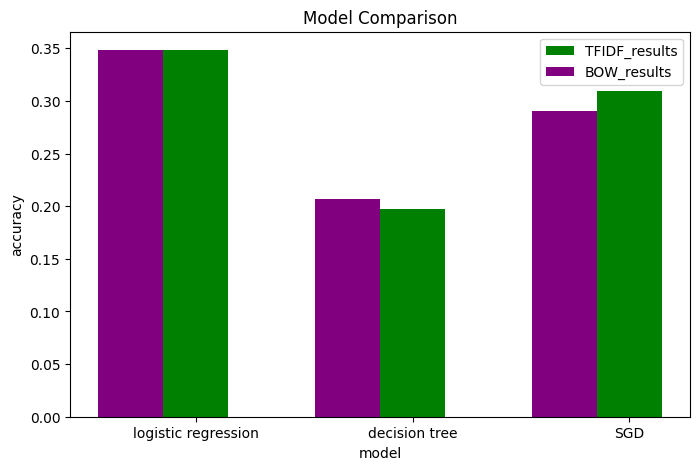

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

TFIDF_results = pd.DataFrame(TFIDF_Result.items(), columns=['model', 'accuracy'])
BOW_results = pd.DataFrame(BOW_Result.items(), columns=['model', 'accuracy'])

y1 = TFIDF_results['accuracy']
y2 = BOW_results['accuracy']

fig, ax = plt.subplots(figsize = (8,5))
ind = np.arange(len(TFIDF_results))

width = 0.3
plt.bar(ind, y1, width, color = 'green')
plt.bar(ind - width, y2, width,color = 'purple')

plt.title('Model Comparison')
plt.xlabel('model')
plt.ylabel('accuracy')
plt.xticks(np.arange(3), ['logistic regression', 'decision tree', 'SGD'])
plt.legend(['TFIDF_results', 'BOW_results'])

**Logistic Regression for Test data**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy score: 0.35948148148148146
              precision    recall  f1-score   support

      action       0.31      0.28      0.29      1369
   adventure       0.29      0.26      0.27      1332
       crime       0.38      0.39      0.39      1399
      family       0.39      0.46      0.42      1325
     fantasy       0.32      0.27      0.29      1345
      horror       0.40      0.42      0.41      1389
     mystery       0.29      0.30      0.29      1323
     romance       0.46      0.59      0.52      1327
       scifi       0.41      0.47      0.44      1347
    thriller       0.24      0.16      0.19      1344

    accuracy                           0.36     13500
   macro avg       0.35      0.36      0.35     13500
weighted avg       0.35      0.36      0.35     13500



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'fantasy'),
  Text(0, 1, 'horror'),
  Text(0, 2, 'family'),
  Text(0, 3, 'scifi'),
  Text(0, 4, 'action'),
  Text(0, 5, 'crime'),
  Text(0, 6, 'adventure'),
  Text(0, 7, 'mystery'),
  Text(0, 8, 'romance'),
  Text(0, 9, 'thriller')])

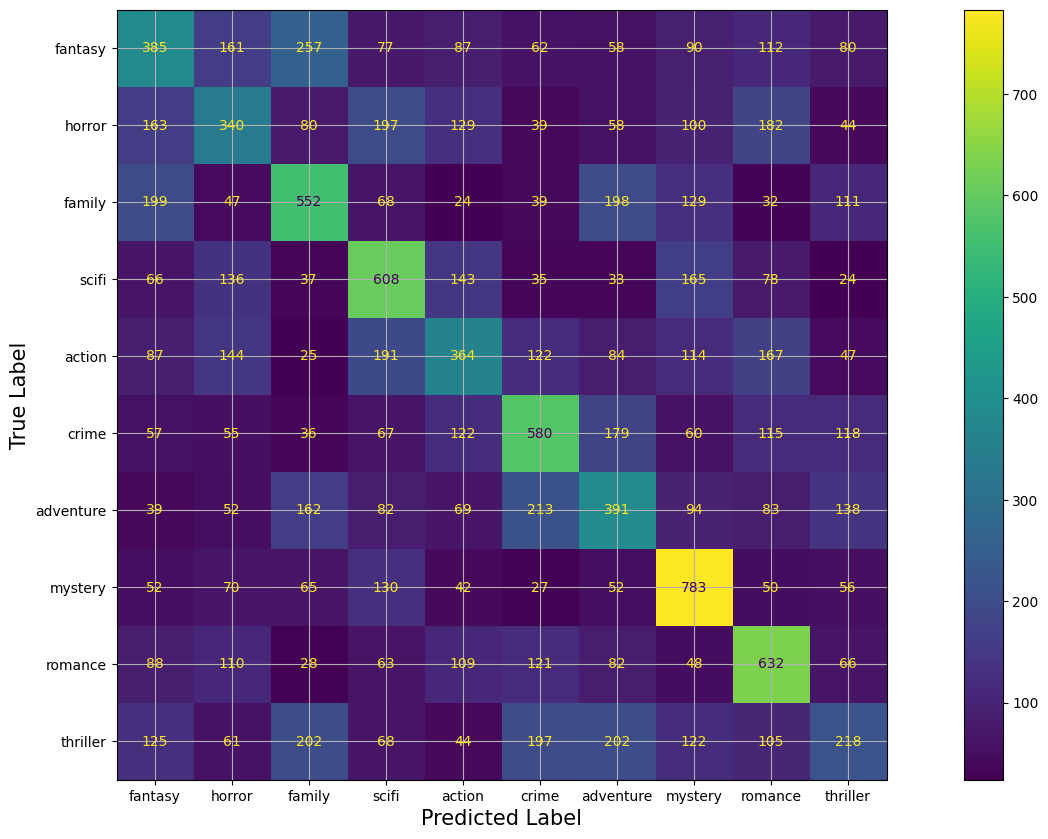

In [47]:
from sklearn.pipeline import Pipeline
%matplotlib inline
import itertools
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


log_reg_pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=25)),
                            ('clf', LogisticRegression(C = 0.1, class_weight = 'balanced', multi_class = 'ovr', penalty = 'l2', solver = 'lbfgs', random_state = 42))])

log_reg_pipeline.fit(X_train, y_train)
y_hat_prob=log_reg_pipeline.predict_proba(X_test)
y_hat = log_reg_pipeline.predict(X_test)
print('Test Accuracy score:', accuracy_score(y_test, y_hat))
print(classification_report(y_test, y_hat))
fig, ax = plt.subplots(figsize=(20,10))
ConfusionMatrixDisplay.from_estimator(log_reg_pipeline, X_test, y_test, ax = ax, display_labels = ['fantasy', 'horror', 'family', 'scifi', 'action', 'crime', 'adventure', 'mystery', 'romance', 'thriller'])
plt.grid(None)
plt.xlabel('Predicted Label', size = 15)
plt.ylabel('True Label', size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10)